<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/Week%207/Assginment/BidirectionalRNN/Review_Toko_Baju_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [28]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

## Data Preparation

In [29]:
# Load dataset
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
df = pd.read_csv(url)

df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [31]:
df.isna().sum()

,0
Unnamed: 0,0
Clothing ID,0
Age,0
Title,3810
Review Text,845
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14


In [32]:
df.duplicated().sum()

np.int64(0)

In [33]:
print(df.columns)

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [34]:
df.dropna(inplace=True)

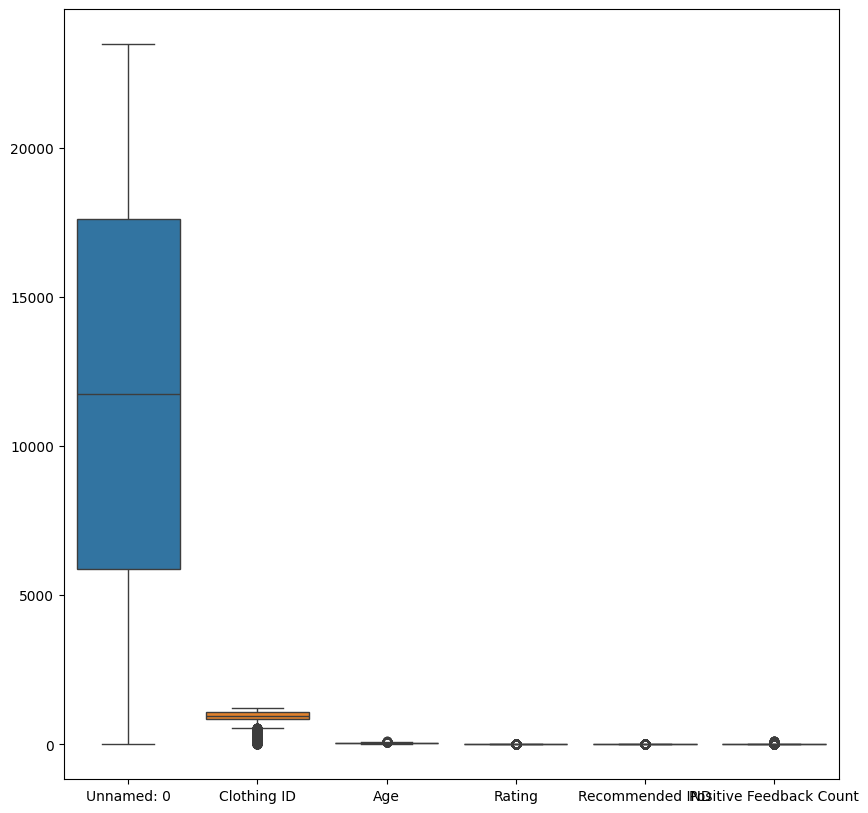

In [35]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df)
plt.show()

## Pre-Processing Data

In [36]:
df = df[['Review Text', 'Rating']].copy()
df.dropna(inplace=True)

def get_sentiment(rating):
    if rating >= 4:
        return 1
    elif rating <= 2:
        return 0
    else:
        return None

df.loc[:, 'Label'] = df['Rating'].apply(get_sentiment)
df.dropna(inplace=True)
df.loc[:, 'Label'] = df['Label'].astype(int)

In [37]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df['Review Text'] = df['Review Text'].apply(clean_text)
df = df[df['Review Text'].str.strip() != '']

In [38]:
X = df['Review Text'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

In [40]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))

## RNN Model

###Recurrent Neural Network (RNN)

Pada RNN, hidden state diperbarui menggunakan input saat ini dan hidden state sebelumnya:

$$
h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)
$$

Output (jika digunakan secara langsung):

$$
y_t = W_{hy} h_t + b_y
$$

In [42]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
                        input_length=max_len))

    model.add(Bidirectional(SimpleRNN(
        units=hp.Int('rnn_units_1', min_value=32, max_value=128, step=32),
        return_sequences=True)))

    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Bidirectional(SimpleRNN(
        units=hp.Int('rnn_units_2', min_value=16, max_value=64, step=16))))

    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(name='auc')]
    )

    return model

## Hyperparameter Tuning

In [43]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_dir',
    project_name='bidirectional_rnn_tuning'
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(X_train_pad, y_train,
             epochs=5,
             validation_data=(X_test_pad, y_test),
             class_weight=class_weights,
             callbacks=[early_stop],
             batch_size=128)

# Get the best model and save it
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save("best_bidirectional_rnn_model.h5")

Reloading Tuner from tuner_dir/bidirectional_rnn_tuning/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Final Training

In [44]:
# Ambil model terbaik dari hasil tuning
best_model = tuner.get_best_models(num_models=1)[0]

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training ulang model terbaik
final_history = best_model.fit(
    X_train_pad, y_train,
    epochs=15,  # misalnya 15, bisa disesuaikan
    validation_data=(X_test_pad, y_test),
    batch_size=128,  # bisa pakai batch_size terbaik dari tuner
    class_weight=class_weights,
    callbacks=[early_stop]
)

# Simpan model final (opsional)
best_model.save("final_bidirectional_rnn_model.h5")

Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9695 - auc: 0.9930 - loss: 0.0957 - precision: 0.9970 - recall: 0.9684 - val_accuracy: 0.9105 - val_auc: 0.9195 - val_loss: 0.2597 - val_precision: 0.9609 - val_recall: 0.9361
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9862 - auc: 0.9977 - loss: 0.0502 - precision: 0.9992 - recall: 0.9851 - val_accuracy: 0.9113 - val_auc: 0.9242 - val_loss: 0.2950 - val_precision: 0.9702 - val_recall: 0.9275
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9910 - auc: 0.9988 - loss: 0.0325 - precision: 0.9993 - recall: 0.9904 - val_accuracy: 0.9247 - val_auc: 0.9080 - val_loss: 0.2703 - val_precision: 0.9537 - val_recall: 0.9609
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9902 - auc: 0.9988 - loss: 0.0329 - precision: 0.9990 - recall: 0.9900 - val_accuracy: 0.9119 - val_auc: 0.9065 - val_loss: 0.3260 - val_precision: 0.9651 - val_recall: 0.9334


## Evaluasi Akurasi

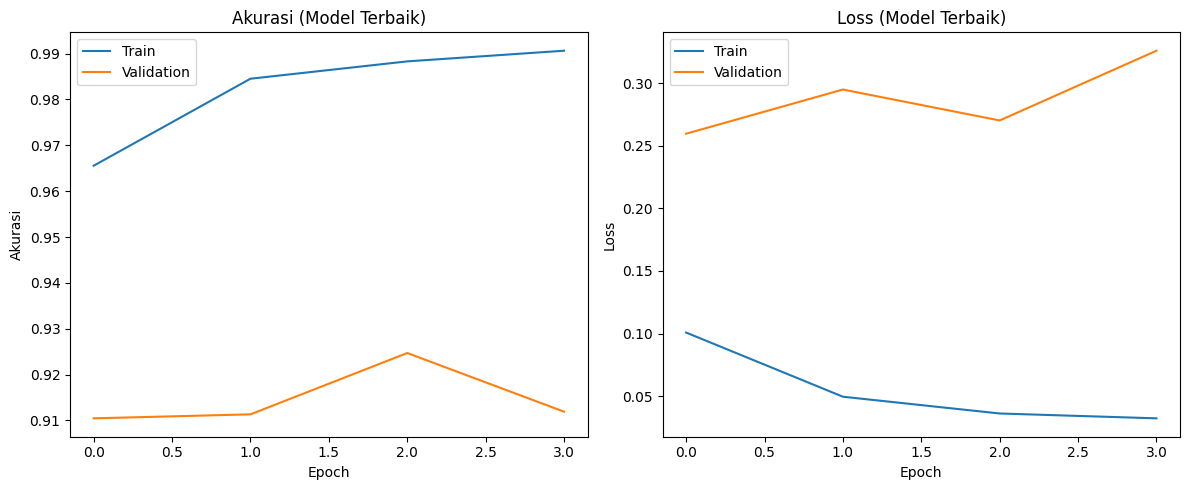

In [45]:
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Train')
plt.plot(final_history.history['val_accuracy'], label='Validation')
plt.title("Akurasi (Model Terbaik)")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], label='Train')
plt.plot(final_history.history['val_loss'], label='Validation')
plt.title("Loss (Model Terbaik)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Akurasi: 0.9105
Presisi: 0.9609
Recall: 0.9361
F1-Score: 0.9483
AUC: 0.9190


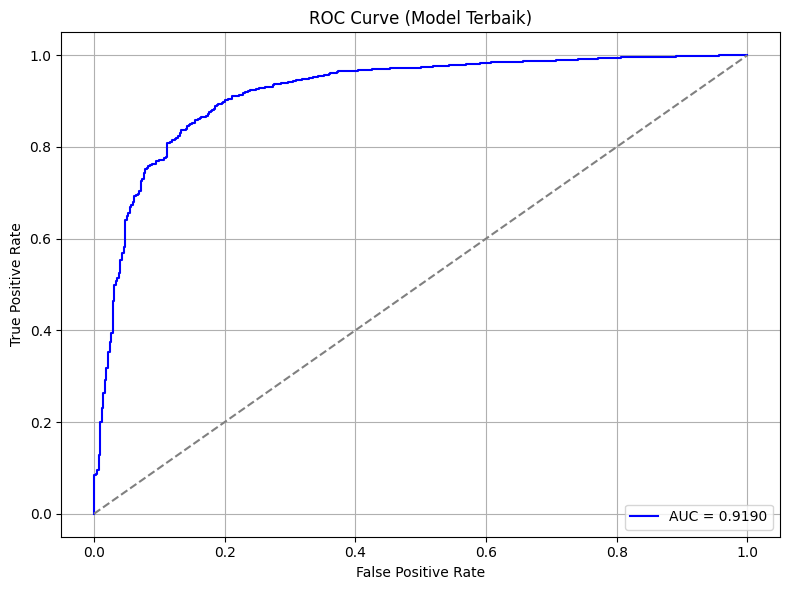

In [51]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Prediksi dan evaluasi
y_pred_prob = best_model.predict(X_test_pad).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrik evaluasi
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_val = roc_auc_score(y_test, y_pred_prob)

print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc_val:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve (Model Terbaik)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 600x500 with 0 Axes>

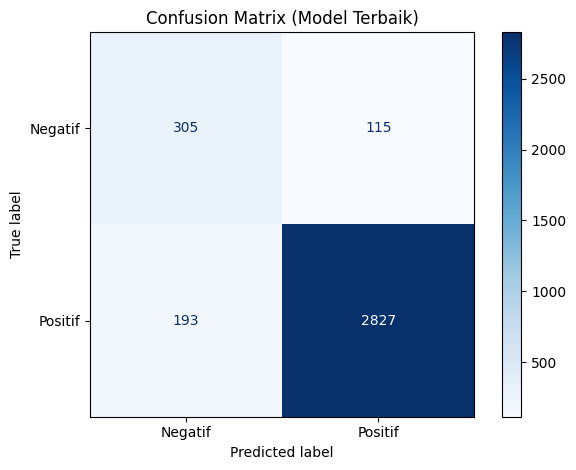

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Tampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatif', 'Positif'])
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Model Terbaik)")
plt.grid(False)
plt.tight_layout()
plt.show()